# Teleportación cuántica con Qiskit

## Análisis teórico y experimental de la teleportación cuántica.  
Simulaciones realizadas con Qiskit (IBM).

**Autores:**  
- Alicia Elvira Montes Núñez  
- María Sáez Díaz  

**Fecha:** Noviembre 2025


In [1]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from IPython.display import display

print("Librerías importadas y listas.")

Librerías importadas y listas.


## 1. Configuración global

En esta sección se configura el acceso a IBM Quantum y se define el estado cuántico que se desea teleportar.

In [2]:
try:
    service = QiskitRuntimeService()
    print("Conexión con IBM Quantum establecida.")
except:
    print("Aviso: No se detectó cuenta de IBM Quantum guardada. La Simulación 3 no se ejecutará correctamente.")

# --- Definición del estado a teleportar ---
# Usamos theta = pi/3 (ejemplo no trivial)
theta = np.pi / 3
initial_state_vector = [np.cos(theta / 2), np.sin(theta / 2)]
SHOTS = 4096

print(f"Estado preparado para teleportar con theta = {theta:.2f}")

qiskit_runtime_service.__init__:WARNING:2025-12-15 16:16:59,932: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: Holi. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


Conexión con IBM Quantum establecida.
Estado preparado para teleportar con theta = 1.05


## 2. Simulación 1: Protocolo ideal

Se implementa el protocolo completo de teleportación cuántica asumiendo hardware perfecto y correcciones clásicas ideales.



--- Ejecutando Simulación 1: Protocolo Ideal ---
Resultados Ideales: {'001': 1015, '010': 1039, '000': 999, '011': 1043}


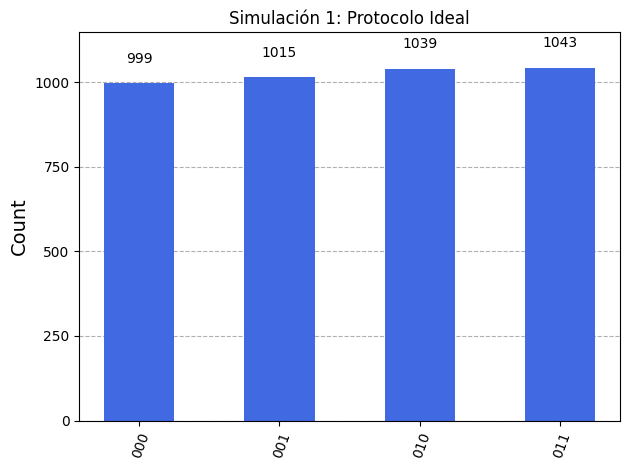

Esquema del Circuito 1:


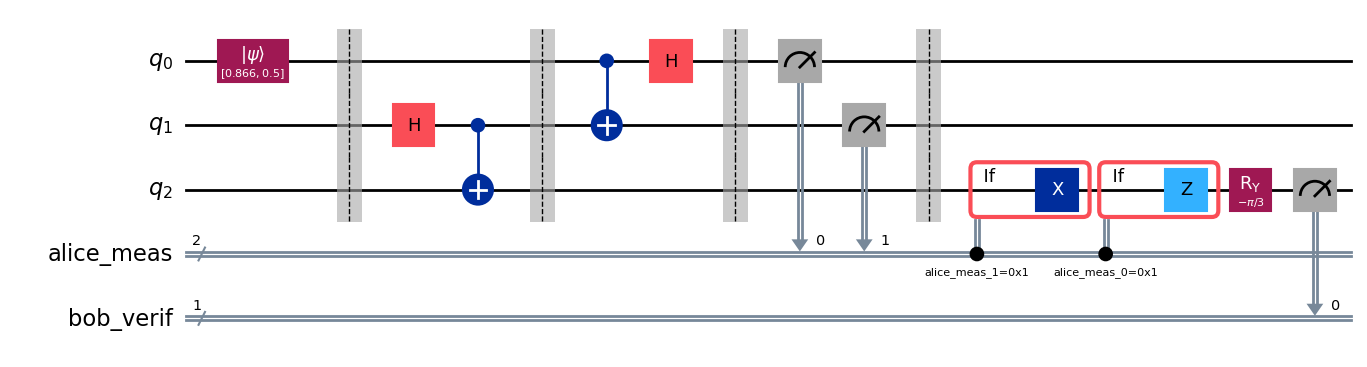

In [3]:
print("\n--- Ejecutando Simulación 1: Protocolo Ideal ---")

qc1 = QuantumCircuit(3)
c_alice = ClassicalRegister(2, "alice_meas")
c_bob_verif = ClassicalRegister(1, "bob_verif")
qc1.add_register(c_alice, c_bob_verif)

# 1. Preparación del estado
qc1.initialize(initial_state_vector, 0)
qc1.barrier()

# 2. Creación del Par EPR (Canal Cuántico)
qc1.h(1)
qc1.cx(1, 2)
qc1.barrier()

# 3. Medida de Bell (Alice)
qc1.cx(0, 1)
qc1.h(0)
qc1.barrier()
qc1.measure([0, 1], c_alice)
qc1.barrier()

# 4. Correcciones Clásicas (Bob)
with qc1.if_test((c_alice[1], 1)):
    qc1.x(2)
with qc1.if_test((c_alice[0], 1)):
    qc1.z(2)

# 5. Verificación (Operación inversa)
qc1.ry(-theta, 2)
qc1.measure(2, c_bob_verif)

# Ejecución en simulador ideal
sim1_sampler = AerSampler(run_options={"shots": SHOTS})
result1 = sim1_sampler.run([qc1]).result()
counts1 = result1.quasi_dists[0].binary_probabilities()

# Visualización de resultados
counts1_int = {k: int(v * SHOTS) for k, v in counts1.items()}
print(f"Resultados Ideales: {counts1_int}")

fig1 = plot_histogram(counts1_int, color='royalblue', title='Simulación 1: Protocolo Ideal')
display(fig1)

# Visualización del circuito
print("Esquema del Circuito 1:")
display(qc1.draw('mpl'))

## 3. Simulación 2: Experimento de 1997

Se reproduce la situación del experimento original eliminando las correcciones clásicas, lo que conduce a un resultado probabilístico.


Resultados Probabilísticos: {'000': 1014, '101': 735, '111': 1060, '001': 272, '110': 250, '010': 765}


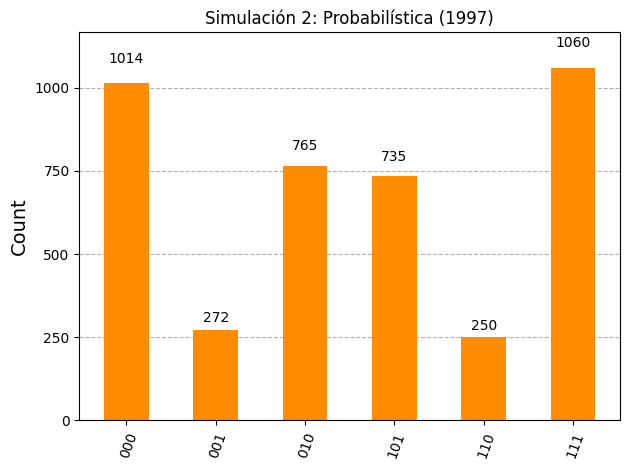

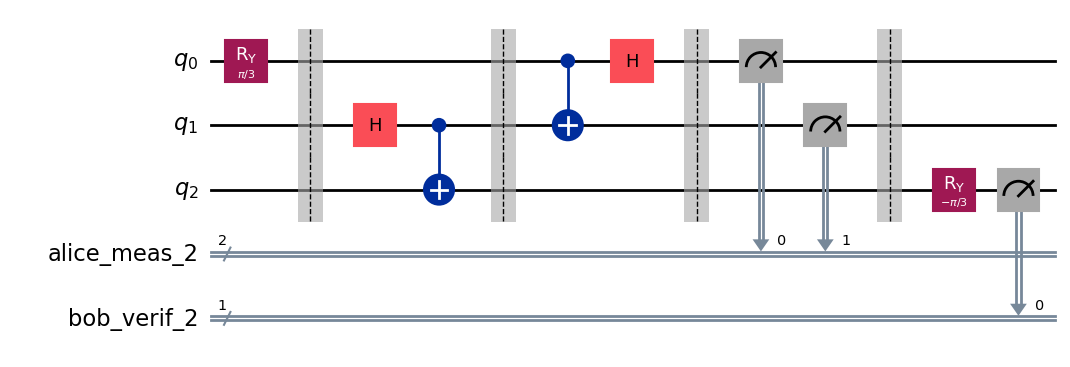

In [5]:
qc2 = QuantumCircuit(3)
c_alice_2 = ClassicalRegister(2, "alice_meas_2")
c_bob_2 = ClassicalRegister(1, "bob_verif_2")
qc2.add_register(c_alice_2, c_bob_2)

# Pasos idénticos a la Simulación 1 (Preparación, EPR, BSM)...
qc2.ry(theta, 0) 
qc2.barrier()
qc2.h(1)         
qc2.cx(1, 2)
qc2.barrier()
qc2.cx(0, 1)     
qc2.h(0)
qc2.barrier()
qc2.measure([0, 1], c_alice_2) 
qc2.barrier()

# ... EXCEPTO AQUÍ: SE ELIMINAN LAS CORRECCIONES CLÁSICAS

# Verificación
qc2.ry(-theta, 2)
qc2.measure(2, c_bob_2)

# Ejecución en simulador ideal
sim2_sampler = AerSampler(run_options={"shots": SHOTS})
result2 = sim2_sampler.run([qc2]).result()
counts2 = result2.quasi_dists[0].binary_probabilities()

# Visualización de resultados
counts2_int = {k: int(v * SHOTS) for k, v in counts2.items()}
print(f"Resultados Probabilísticos: {counts2_int}")

fig2 = plot_histogram(counts2_int, color='darkorange', title='Simulación 2: Probabilística (1997)')
display(fig2)

# Visualización del circuito
display(qc2.draw('mpl'))

## 4. Simulación 3: Hardware real

Se ejecuta el circuito transpilado en un backend real de IBM Quantum para observar los efectos del ruido y obtener la fidelidad experimental.



--- Ejecutando Simulación 3: Hardware Real ---


qiskit_runtime_service.backends:WARNING:2025-12-15 16:19:46,820: Loading instance: Holi, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-15 16:19:49,420: Using instance: Holi, plan: open


Backend elegido: ibm_fez
Enviando trabajo a IBM (esto puede tardar unos minutos)...
ID del job: d502e6fg0u6s73dbbmeg
Resultados recibidos.
Fidelidad observada: 94.92%


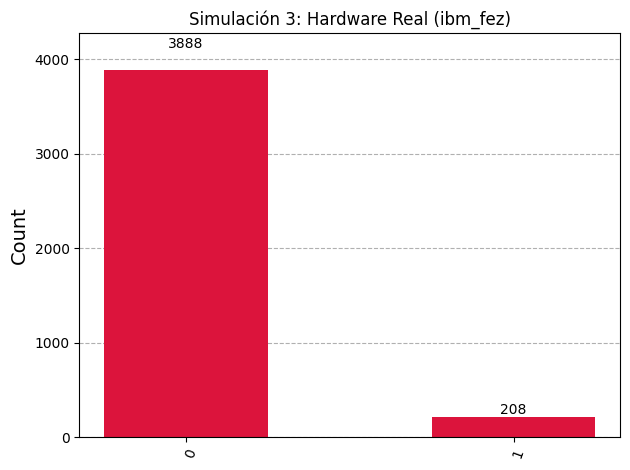

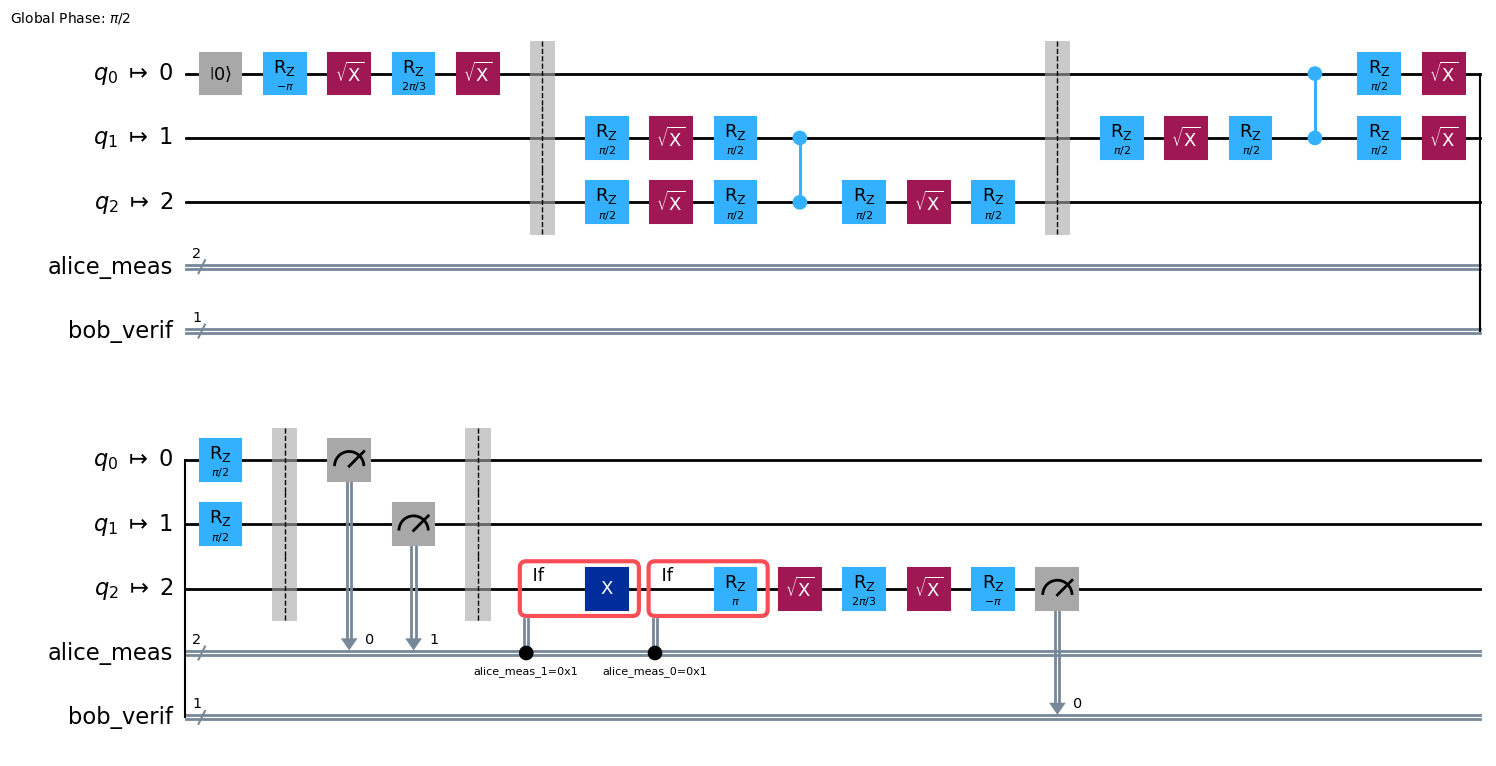

In [6]:
print("\n--- Ejecutando Simulación 3: Hardware Real ---")

try:
    # 1. Buscar backend real menos ocupado
    backend_real = service.least_busy(simulator=False, operational=True, min_num_qubits=3)
    print(f"Backend elegido: {backend_real.name}")

    # 2. Transpilación del circuito ideal
    pm = generate_preset_pass_manager(backend=backend_real, optimization_level=1)
    tp_qc1 = pm.run(qc1)

    # 3. Ejecución
    sampler_real = Sampler(mode=backend_real)
    print("Enviando trabajo a IBM (esto puede tardar unos minutos)...")
    job3 = sampler_real.run([tp_qc1], shots=SHOTS)
    print(f"ID del job: {job3.job_id()}")
    
    # Esperar resultados
    result3 = job3.result()
    print("Resultados recibidos.")

    # 4. Análisis
    pub_result = result3[0]
    counts3 = pub_result.data['bob_verif'].get_counts()
    
    fidelidad = counts3.get('0', 0) / SHOTS
    print(f"Fidelidad observada: {fidelidad*100:.2f}%")

    # Visualización
    fig3 = plot_histogram(counts3, color='crimson', title=f'Simulación 3: Hardware Real ({backend_real.name})')
    display(fig3)
    
    # Mostrar circuito transpilado
    display(tp_qc1.draw('mpl', idle_wires=False, fold=20))

except Exception as e:
    print(f"No se pudo ejecutar en hardware real. Error: {e}")